# Imports

In [25]:
import pandas as pd
import numpy as np
import random as r
from os.path import join
from PIL import Image
import os
import shutil
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action="ignore",category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module="keras")
%matplotlib inline
import itertools
from PIL import Image as pImage, ImageOps

from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Input, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Global Variables

In [2]:
# Global Variables
IMAGE_DATA_RESIZE = (448,448)
IMAGE_TRAIN_SIZE = (224,224)
IMAGE_TRAIN_SIZE = IMAGE_DATA_RESIZE
ZOOM_FACTOR = 1.5
T_WEIGHTS = {
    "train":8,
    "test":1,
    "valid":1
}
EPOCH_NUMBER = 5

 ## Function for splitting file paths in the list into Training, Validating, and Testing Sets

In [18]:
def organize_data(file_list, train=T_WEIGHTS['train'],test=T_WEIGHTS['test'], valid= T_WEIGHTS['valid']):
    if not file_list:
        return [], [], []  # Return empty lists if input is empty
    
    r.shuffle(file_list)

    # Calculate split indices
    total_weight = train + test + valid
    train_end = int(len(file_list) * (train / total_weight))
    test_end = train_end + int(len(file_list) * (test / total_weight))

    # Split the list
    train_list = file_list[:train_end]
    test_list = file_list[train_end:test_end]
    valid_list = file_list[test_end:]

    return train_list, test_list, valid_list



## Create data folderd based on all the units

In [19]:

dice = join("data","dicetype")
dice_type_list = ["d4","d6","d8","d10","d12","d20"]

if not os.path.isdir(join(dice,"train")):
    os.makedirs(join(dice,"train"))
    os.makedirs(join(dice,"test"))
    os.makedirs(join(dice,"valid"))

    for t in dice_type_list:
        os.makedirs(join(dice,"train",str(t)))
        os.makedirs(join(dice,"test",str(t)))
        os.makedirs(join(dice,"valid",str(t)))

        # Grabbing file names and list
        file_list = [name for name in os.listdir(join(dice,str(t)))]
        # dir_len = len(file_list)

        f_train, f_test, f_valid = organize_data(file_list)

        for f in file_list:
            with pImage.open(join(dice,str(t),f)) as img:
                # Correct the orientation based on EXIF metadata
                img = ImageOps.exif_transpose(img)

                #Zoom in on the image assuming the dice is in the middle
                width, height = img.size
                crop_width = width // ZOOM_FACTOR
                crop_height = height // ZOOM_FACTOR
                left = (width - crop_width) // 2
                top = (height - crop_height) // 2
                right = left + crop_width
                bottom = top + crop_height
                crop_box = (left, top, right, bottom)
                cropped_img = img.crop(crop_box)

                # Resize image for training
                resized_img = cropped_img.resize(IMAGE_DATA_RESIZE)

                if f in f_train:
                    resized_img.save(join(dice,"train", str(t), f))
                elif f in f_test:
                    resized_img.save(join(dice,"test", str(t), f))
                elif f in f_valid:
                    resized_img.save(join(dice,"valid", str(t), f))
                else:
                    raise ValueError(f"{f} not in file_list")
    
        print(f"Done With Folder # {t}")



## Create batches based on training paths

In [20]:
train_path = join(dice,"train")
test_path =  join(dice,"test")
valid_path = join(dice,"valid")

model_classes = dice_type_list

train_batches = ImageDataGenerator(
    # rotation_range=10,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # shear_range=0.15,
    # zoom_range=0.1,
    # horizontal_flip=True,
    # fill_mode='nearest',
    preprocessing_function = tf.keras.applications.vgg16.preprocess_input
).flow_from_directory(directory=train_path, target_size=(IMAGE_TRAIN_SIZE), classes=model_classes, batch_size=10)
    
valid_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(IMAGE_TRAIN_SIZE), classes=model_classes, batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(IMAGE_TRAIN_SIZE), classes=model_classes, batch_size=10, shuffle=False)

Found 13107 images belonging to 6 classes.
Found 1642 images belonging to 6 classes.
Found 1637 images belonging to 6 classes.


In [21]:
# Check the total number of images
print(f"Total training samples: {train_batches.samples}")
print(f"Total validation samples: {valid_batches.samples}")
print(f"Total test samples: {test_batches.samples}")

Total training samples: 13107
Total validation samples: 1642
Total test samples: 1637


## Make sure that the correct images are fed into the Model

In [22]:
# Plot images
def plotImages(images_arr, convertRGB = False):
        fig, axes = plt.subplots(1,10, figsize=(20,20))
        axes = axes.flatten()
        for img, ax in zip(images_arr, axes):
            if convertRGB:
                if img.shape[-1] == 3:  # Check if the image has 3 channels (RGB)
                    img = img[..., ::-1]  # Convert BGR to RGB (reverse last dimension)
            ax.imshow(img)
            # ax.axis('off')
        plt.tight_layout()
        plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-36.779..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-71.939..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-69.68..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-62.939003..151.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-116.779..141.061].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-88.779..151.061].
Clipping input da

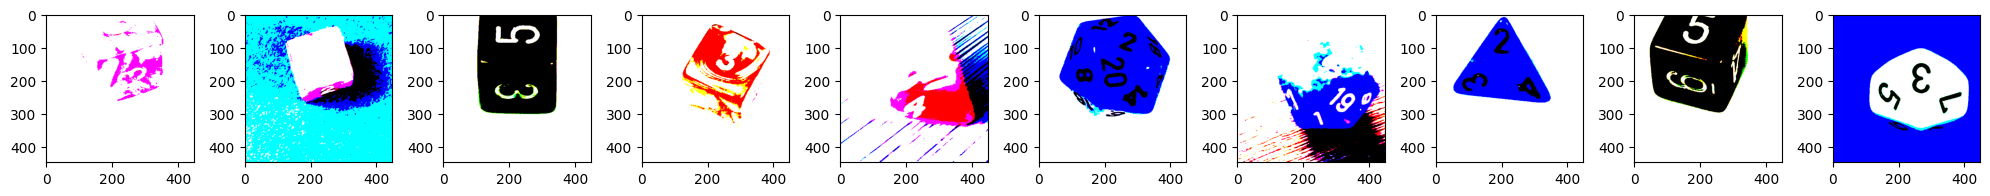

[[0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0.]]


In [23]:
imgs, labels = next(train_batches)

plotImages(imgs)
print(labels)

# Create and Run Model on batch image data

In [31]:
model = Sequential([
    Input(shape=(IMAGE_TRAIN_SIZE[0],IMAGE_TRAIN_SIZE[1],3)),
    Conv2D(filters=16, kernel_size=(3,3), activation="relu", padding = 'same'),
    MaxPool2D(pool_size=(2,2), strides = 2),
    Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding = 'same'),
    MaxPool2D(pool_size=(2,2), strides = 2),
    Flatten(),
    Dense(units=6, activation="softmax")
])
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 448, 448, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 224, 224, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 224, 224, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 401408)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 6)                   │       2,408,454 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,413,542 (9.21 MB)

 Trainable params: 2,413,542 (9.21 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy",])
model.fit(x=train_batches, validation_data=valid_batches, epochs=EPOCH_NUMBER, verbose=2)

Epoch 1/5
1311/1311 - 720s - 549ms/step - accuracy: 0.8198 - loss: 9.0310 - val_accuracy: 0.9135 - val_loss: 0.3315
Epoch 2/5


KeyboardInterrupt: 

# Confusion Matrix

In [11]:
def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion Matrix", cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize=True'
    """

    plt.imshow(cm,interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[: ,np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print("Confusion matrix without normalization")

    # print(cm)

    thresh = cm.max()/2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j,i, cm[i,j],
                horizontalalignment="center",
                color="white" if cm[i,j] > thresh else "black")
        
    plt.tight_layout()
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")

Confusion matrix without normalization


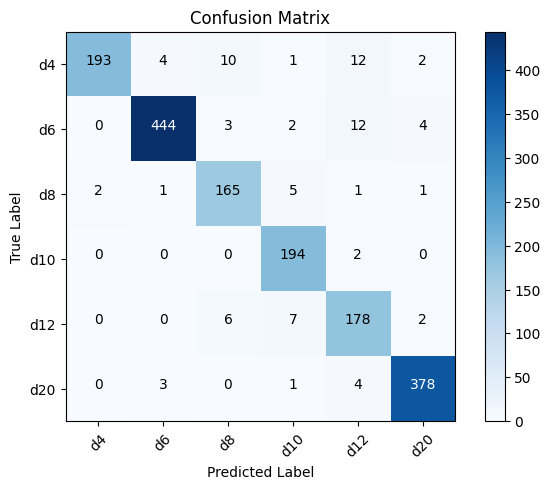

In [12]:
# Use the model to predict the test batches
predictions = model.predict(x=test_batches, verbose=0)
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

Confusion matrix without normalization


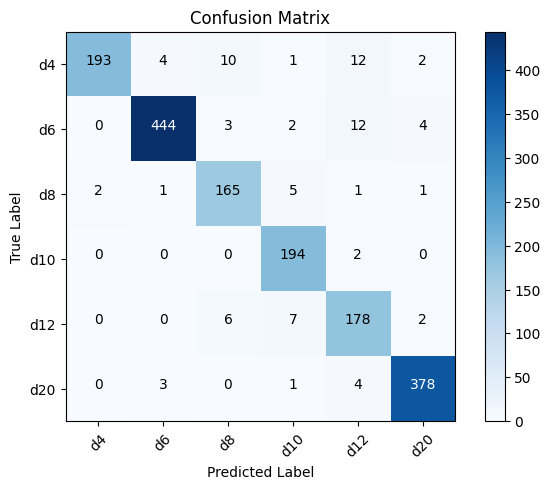

In [17]:
plot_confusion_matrix(cm=cm, classes=model_classes, title="Confusion Matrix")

### Save model

In [15]:
model_path = join("models","dice_type_classification3.keras")
if os.path.isfile(model_path) is False:
    model.save(model_path)